## 4. La Tercera Ley de Kepler a partir de una Regresión Lineal Múltiple

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
df = pd.read_csv("https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=cumulative&select=koi_period,koi_sma,koi_smass&format=csv")

In [3]:
nans_per_col = df.isna().sum(axis=0)
nans_per_col

koi_period      0
koi_sma       363
koi_smass     363
dtype: int64

In [4]:
kepler_data = df[['koi_period', 'koi_sma', 'koi_smass']]
kepler_data_clean = kepler_data.dropna().reset_index(drop=True)

print(f"Datos limpios: {kepler_data_clean.shape[0]} filas")
print(kepler_data_clean)

Datos limpios: 9201 filas
      koi_period  koi_sma  koi_smass
0       9.488036   0.0853      0.919
1      54.418383   0.2734      0.919
2      19.899140   0.1419      0.961
3       1.736952   0.0267      0.836
4       2.525592   0.0374      1.095
...          ...      ...        ...
9196    0.527699   0.0128      1.005
9197    1.739849   0.0290      1.075
9198    0.681402   0.0157      1.104
9199  333.486169   1.2233      2.190
9200    4.856035   0.0606      1.260

[9201 rows x 3 columns]


In [5]:
corr = kepler_data_clean.corr()
print(corr)

            koi_period   koi_sma  koi_smass
koi_period    1.000000  0.871817  -0.004991
koi_sma       0.871817  1.000000   0.058292
koi_smass    -0.004991  0.058292   1.000000


In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

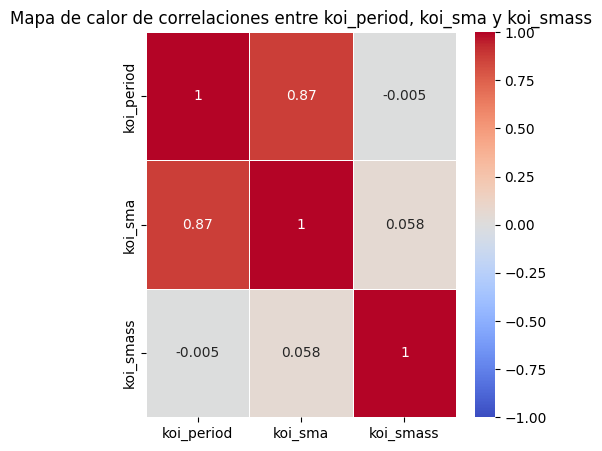

In [7]:
plt.figure(figsize=(5,5))
sns.heatmap(corr, vmin=-1, vmax=1, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Mapa de calor de correlaciones entre koi_period, koi_sma y koi_smass')
plt.show()

In [16]:
def filter(df, column, valor):
  iqr_col = df[column].quantile(0.75) - df[column].quantile(0.25)
  filter_min = df[column] > df[column].quantile(0.25) - iqr_col * valor
  filter_max = df[column] < df[column].quantile(0.75) +   iqr_col* valor
  return df[filter_min & filter_max]

In [22]:
filtered_ln = filter(kepler_data_clean, 'koi_period', 2)  
filtered_ln = filter(filtered_ln, 'koi_sma', 2)     
filtered_ln = filter(filtered_ln, 'koi_smass', 2)

print("Columnas antes de agregar logaritmos:", filtered_ln.columns)

Columnas antes de agregar logaritmos: Index(['koi_period', 'koi_sma', 'koi_smass'], dtype='object')


In [24]:
filtered_ln['ln_period'] = np.log(filtered_ln['koi_period'] * 86400)  # Días a segundos, luego logaritmo
filtered_ln['ln_axis'] = np.log(filtered_ln['koi_sma'] * 1.496e11)    # AU a metros, luego logaritmo
filtered_ln['ln_mass'] = np.log(filtered_ln['koi_smass'] * 1.9884e30) # Masas solares a kg, luego logaritmo

#print("Columnas después de agregar logaritmos:", filtered_ln.columns)

filtered = filtered_ln.drop(['koi_smass', 'koi_sma', 'koi_period'], axis=1)
#print("Columnas después de eliminar originales:", filtered.columns)

print(filtered.head())

   ln_period    ln_axis    ln_mass
0  13.616775  23.269650  69.680414
1  15.363445  24.434412  69.680414
2  14.357419  23.778598  69.725102
3  11.918875  22.108139  69.585756
4  12.293218  22.445146  69.855637


Text(0.5, 1.0, 'Tabla de correlación de Pearson')

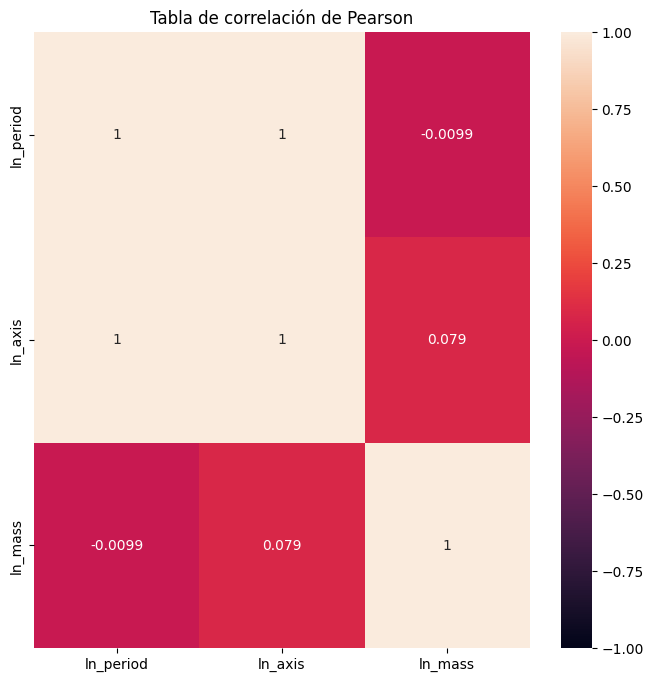

In [25]:
plt.figure(figsize=(8,8))
ax = sns.heatmap(filtered.corr(), vmin=-1, vmax=1, annot=True)
ax.set_title('Tabla de correlación de Pearson')

In [26]:
#Regresión lineal

y = filtered['ln_mass']
X = filtered[['ln_axis', 'ln_period']]

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [31]:
print(f"Tamaño del conjunto de entrenamiento: {X_train.shape}")
print(f"Tamaño del conjunto de prueba: {X_test.shape}")

Tamaño del conjunto de entrenamiento: (4982, 2)
Tamaño del conjunto de prueba: (2136, 2)


In [34]:
modelo = LinearRegression()
modelo.fit(X_train, y_train)
r2_score = modelo.score(X_test, y_test)

print("Coeficientes de la regresión:", modelo.coef_)
print("Intercepto de la regresión:", modelo.intercept_)
print(f"Coeficiente de determinación (R^2) en el conjunto de prueba: {r2_score:.4f}")

Coeficientes de la regresión: [ 2.93623584 -1.9578457 ]
Intercepto de la regresión: 28.01463192813099
Coeficiente de determinación (R^2) en el conjunto de prueba: 0.9991


In [35]:
y_pred = modelo.predict(X)
print("Predicciones en el conjunto de prueba:", y_pred[:5])

Predicciones en el conjunto de prueba: [69.68026889 69.68057208 69.72459215 69.59402419 69.85065023]


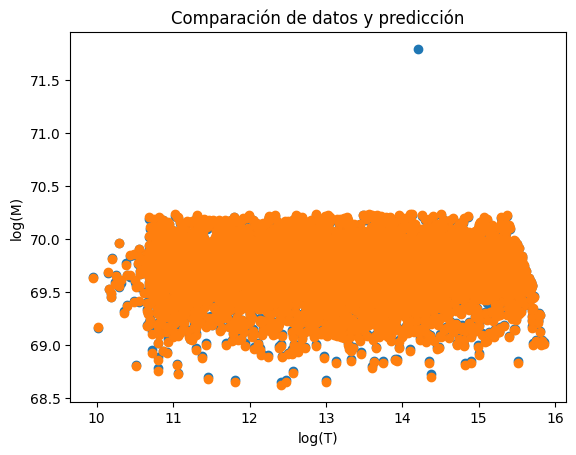

In [39]:
plt.scatter(X['ln_period'], y_pred)
plt.scatter(X['ln_period'], y)
plt.title('Comparación de datos y predicción')
plt.xlabel('log(T)')
plt.ylabel('log(M)')
plt.show()

In [40]:
from sklearn.model_selection import cross_validate

In [41]:
scores1 = cross_validate(modelo, X, y, scoring='r2')
print(scores1)

{'fit_time': array([0.00400686, 0.00350571, 0.00350738, 0.00352216, 0.00300455]), 'score_time': array([0.00299907, 0.00200748, 0.00200772, 0.00199461, 0.00203991]), 'test_score': array([0.99899925, 0.99906926, 0.99923022, 0.93933157, 0.99912898])}


In [42]:
print(f'Score of Linear Regression model: {scores1["test_score"].mean():.3f} +/- {scores1["test_score"].std():.3f}')

Score of Linear Regression model: 0.987 +/- 0.024


In [45]:
# REGRESIÓN LINEAL USANDO RED NEURONAL

import tensorflow as tf

In [70]:
layer0=tf.keras.layers.Dense(units=1, input_dim=2, activation='linear') #En units se asigna el número de neuronas
"""En imput_dim se asigna la capa de entrada"""
"""Linear es porque seguiremos con una regresión lineal"""
modelo = tf.keras.Sequential([layer0])

modelo.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.2), metrics=['mean_squared_error'])

C:\Users\Sital\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [74]:
history = modelo.fit(X_train, y_train, epochs=100, verbose=True, validation_split=0.01)

Epoch 1/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1026.2175 - mean_squared_error: 1026.2175 - val_loss: 13.1629 - val_mean_squared_error: 13.1629
Epoch 2/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 13.9187 - mean_squared_error: 13.9187 - val_loss: 11.3418 - val_mean_squared_error: 11.3418
Epoch 3/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11.8371 - mean_squared_error: 11.8371 - val_loss: 8.6289 - val_mean_squared_error: 8.6289
Epoch 4/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.1386 - mean_squared_error: 9.1386 - val_loss: 6.8814 - val_mean_squared_error: 6.8814
Epoch 5/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.8631 - mean_squared_error: 6.8631 - val_loss: 4.7516 - val_mean_squared_error: 4.7516
Epoch 6/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.6933 - mean_squared_error: 4.6933 - val_loss: 3.1386 - val_mean_squared_error: 3.1386
Epoch 7/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.1740 - mean_squared_error: 3.

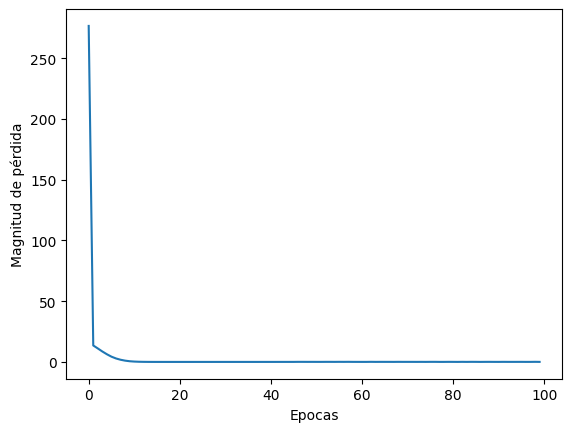

In [75]:
plt.plot(history.history['loss'])
plt.xlabel('Epocas')
plt.ylabel('Magnitud de pérdida')
plt.show()

In [76]:
from sklearn.metrics import r2_score

Y_pred = modelo.predict(X_test)
r2_score(y_test, Y_pred)

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


0.854147360569419

In [77]:
layer0.get_weights()

[array([[ 3.9794765],
        [-2.647477 ]], dtype=float32),
 array([13.17185], dtype=float32)]

In [78]:
from operator import mul
#Log(C) = Log(M) - 3*Log(a)+2*Log(T)
#G = 4*pi**2/C
wt = [1.0, -3.0, 2.0]
log_C = filtered.iloc[:,:].mul(wt, axis=1).sum(axis=1)
g_constant = log_C.apply(lambda x: 4*(np.pi**2)/np.exp(x))
g_constant[0]

2.9969053874906543e-35

In [79]:
g_constant.min()

8.129297879354926e-37

In [80]:
g_constant.max()

5.4647469275939865e-34

In [81]:
g_filtered = g_constant[g_constant < 1e-10]

In [82]:
len(g_constant) - len(g_filtered)

0

[Text(0, 0.5, 'Frecuencia')]

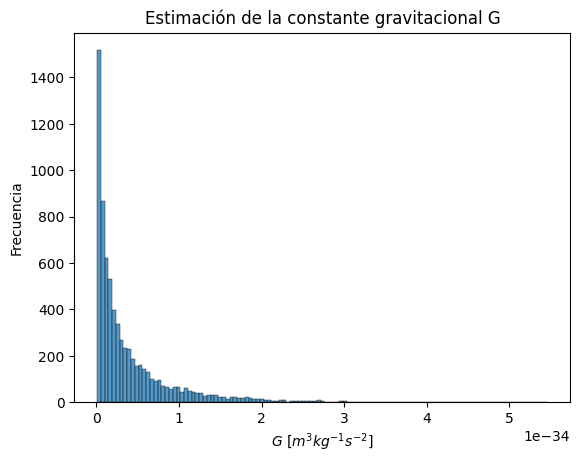

In [83]:
ax = sns.histplot(g_filtered)
ax.set_title('Estimación de la constante gravitacional G')
ax.set(xlabel=r'$G$ [$m^3 kg^{-1}s^{-2}$]')
ax.set(ylabel='Frecuencia')

In [84]:
g_filtered.skew(), g_filtered.kurtosis()

(0.0, 0.0)

In [85]:
print(f'El estimado de la constante gravitaciional es: {g_filtered.mean()} +/- {g_filtered.std()}')

El estimado de la constante gravitaciional es: 3.922303675546087e-35 +/- 5.179603228743767e-35
